In [1]:
%%time

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

warnings.filterwarnings('ignore')

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CPU times: user 1.61 s, sys: 324 ms, total: 1.93 s
Wall time: 3.75 s


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DATABASE

In [3]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset

# # Load and prepare data
# class MovieReviewDataset(Dataset):
#     def __init__(self, dataframe, tokenizer, max_len):
#         self.tokenizer = tokenizer
#         self.data = dataframe
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         review = self.data.iloc[index]
#         inputs = self.tokenizer.encode_plus(
#             review['Content'],
#             None,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             return_token_type_ids=True,
#             truncation=True
#         )
#         input_ids = inputs['input_ids']
#         attention_mask = inputs['attention_mask']
#         label = 1 if review['Sentiment'] == 'Positive' else 0
#         return {
#             'input_ids': torch.tensor(input_ids, dtype=torch.long),
#             'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
#             'labels': torch.tensor(label, dtype=torch.long)
#         }

# # Example data loading and preparation
# data = []
# folder_path = 'movies/docs'  # Adjust the path to your dataset folder

# for filename in os.listdir(folder_path):
#     if filename.endswith('.txt'):
#         with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
#             content = file.read().replace('\n', ' ')
#         sentiment = 'Negative' if filename.startswith('negR') else 'Positive'
#         id = f"N{filename[5:8]}" if sentiment == 'Negative' else f"P{filename[5:8]}"
#         data.append({'Content': content, 'Sentiment': sentiment, 'id': id})

# # Convert to DataFrame
# df = pd.DataFrame(data)

# # Sort the DataFrame by 'id'
# df = df.sort_values(by='id').reset_index(drop=True)

# # Separate the dataset
# train_neg = df[df['Sentiment'] == 'Negative'][:800]
# val_neg = df[df['Sentiment'] == 'Negative'][800:900]
# test_neg = df[df['Sentiment'] == 'Negative'][900:1000]

# train_pos = df[df['Sentiment'] == 'Positive'][:800]
# val_pos = df[df['Sentiment'] == 'Positive'][800:900]
# test_pos = df[df['Sentiment'] == 'Positive'][900:1000]

# # Concatenate the splits
# train_df = pd.concat([train_neg, train_pos]).sample(frac=1).reset_index(drop=True)
# val_df = pd.concat([val_neg, val_pos]).sample(frac=1).reset_index(drop=True)
# test_df = pd.concat([test_neg, test_pos]).sample(frac=1).reset_index(drop=True)

# # Create datasets and dataloaders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# train_dataset = MovieReviewDataset(train_df.sample(frac=1, random_state=200), tokenizer, max_len=128)
# val_dataset = MovieReviewDataset(val_df, tokenizer, max_len=128)
# test_dataset = MovieReviewDataset(test_df, tokenizer, max_len=128)

# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/movies_reviews_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/movies_reviews_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/movies_reviews_test.csv')

print(test_df.head())

                                             Content Sentiment    id
0  there may not be a critic alive who harbors as...  Negative  N900
1  renee zellweger stars as sonia , a young jewis...  Negative  N901
2  there 're so many things to criticize about i ...  Negative  N902
3  do n't let this movie fool you into believing ...  Negative  N903
4  it 's a good thing most animated sci - fi movi...  Negative  N904


## MODEL

In [5]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, n_filters, (fs, embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)  # [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  # [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

# Create the CNN instance
INPUT_DIM = len(tokenizer.get_vocab())  # Use tokenizer vocabulary size
EMBEDDING_DIM = 512
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4]
OUTPUT_DIM = 2  # Binary classification
DROPOUT = 0.5

model_path = '/content/drive/MyDrive/model.pth'
model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
model = model.to(device)
model.eval()

# Step 4: Load the state dictionary into the model instance
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## XAI TECHNIQUES

In [6]:
# Tokenize the example text
text = "Thanks to Manhattan's traffic I was late again."
#text = test_df.iloc[0,0]


inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

# Ensure input is also on the same device as the model
inputs = inputs.to(device)

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [7]:
# Define a model wrapper for Captum
class CNNModelWrapper(nn.Module):
    def __init__(self, model):
        super(CNNModelWrapper, self).__init__()
        self.model = model

    def forward(self, input_ids):
        embedded = self.model.embedding(input_ids)
        embedded = embedded.unsqueeze(1)  # [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.model.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.model.dropout(torch.cat(pooled, dim=1))
        output = self.model.fc(cat)
        return output

# Prepare model and wrapper
wrapper = CNNModelWrapper(model)

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def visualize_attributions(attributions, input_ids):
    # Sum the attributions across embedding dimensions and normalize them
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)  # Normalizing attributions
    weights = attributions.detach().cpu().numpy()

    # Convert input IDs to tokens
    words = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

    # Skip the first and last token (usually [CLS] and [SEP])
    words = words[1:-1]
    weights = weights[1:-1]

    # Check if the number of weights matches the number of words
    if len(words) != len(weights):
        raise ValueError("The number of weights must match the number of words in the text.")

    # Create a custom color map
    colors = ["red", "lightgrey", "green"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    # Normalize weights to be between -1 and 1
    norm = plt.Normalize(-1, 1)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(len(words) * 1, 2))
    ax.axis('off')

    # Plot each word with its corresponding background color
    x_pos = 0
    for word, weight in zip(words, weights):
        color = cmap(norm(weight))
        ax.text(x_pos, 0.5, word, fontsize=12, weight='bold', color='black',
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.5'))
        x_pos += len(word) * 0.5  # Adjust spacing between words

    # Adjust the plot
    plt.xlim(-0.5, x_pos)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.show()

In [9]:
def normalize_attributions(attributions):
    attributions_l2 = attributions.norm(p=2, dim=-1).squeeze(0)

    # remove CPAD and CLS
    attributions_l2 = attributions_l2[1:-1]

    # Normalize attributions_l2 to be between 0 and 1
    attributions_l2 = attributions_l2 / torch.max(attributions_l2)

    ## mean
    attributions_mean = attributions.sum(dim=-1).squeeze(0)
    attributions_mean = attributions_mean / torch.norm(attributions_mean)
    attributions_mean = attributions_mean[1:-1]

    # Normalize attributions_mean to be between 0 and 1
    attributions_mean = (attributions_mean - attributions_mean.min()) / (attributions_mean.max() - attributions_mean.min())

    return attributions_l2, attributions_mean

In [10]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [11]:
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

# Configure interpretable embedding layer for Captum
interpretable_embedding = configure_interpretable_embedding_layer(model, 'embedding')


# Since the model outputs a single logit for binary classification, set target to 0 (for the logit itself)
target_index = 0

#### Deep Lift

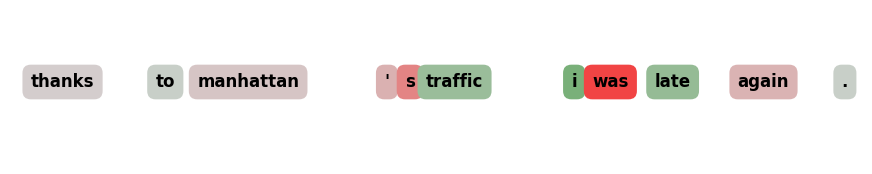

CPU times: user 699 ms, sys: 258 ms, total: 957 ms
Wall time: 1.87 s


In [12]:
%%time

from captum.attr import DeepLift

def xai_deeplift(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = DeepLift(wrapper)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp, temp_l2,temp_mean = xai_deeplift(wrapper, input_ids, target_index, visual=True)

#### Grad L2 Norm

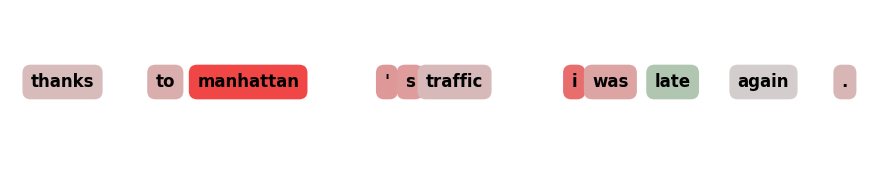

CPU times: user 566 ms, sys: 286 ms, total: 852 ms
Wall time: 1.29 s


In [13]:
%%time

from captum.attr import DeepLift

def xai_gradl2(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    assert input_embeddings.requires_grad, "Input embeddings must have requires_grad=True."
    input_embeddings.retain_grad()

    res_w = wrapper(input_embeddings)
    output = res_w[:, target]

    output.backward(torch.ones_like(output))
    attributions = input_embeddings.grad

    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp, temp_l2,temp_mean = xai_gradl2(wrapper, input_ids, target_index, visual=True)

#### Saliency

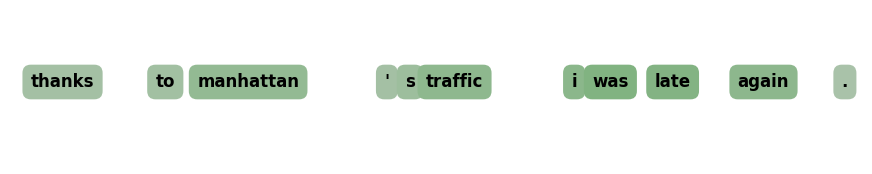

CPU times: user 92.1 ms, sys: 156 ms, total: 248 ms
Wall time: 84.8 ms


In [14]:
%%time

from captum.attr import Saliency

def xai_saliency(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = Saliency(wrapper)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_saliency(wrapper, input_ids, target_index, visual=True)

#### Integrated Gradients

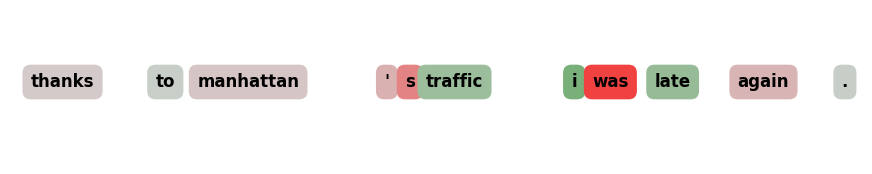

CPU times: user 150 ms, sys: 200 ms, total: 349 ms
Wall time: 188 ms


In [15]:
%%time

from captum.attr import IntegratedGradients

def xai_integratedgradients(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = IntegratedGradients(wrapper)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_integratedgradients(wrapper, input_ids, target_index, visual=True)

#### Input X Gradient

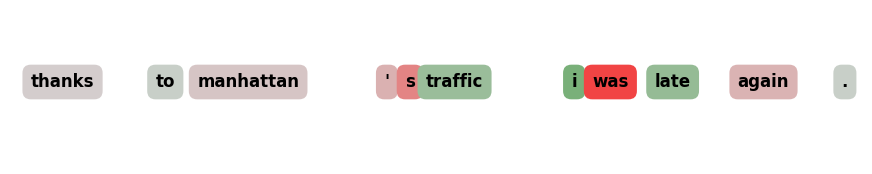

CPU times: user 120 ms, sys: 137 ms, total: 257 ms
Wall time: 85.3 ms


In [16]:
%%time

from captum.attr import InputXGradient

def xai_inputgradient(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = InputXGradient(wrapper)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_inputgradient(wrapper, input_ids, target_index, visual=True)

#### Shapley Values

In [17]:
#%%time
#
#from captum.attr import ShapleyValueSampling
#
#def xai_shapley(model, input, target, visual=False):
#
#    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
#    xai = ShapleyValueSampling(wrapper)
#    attributions = xai.attribute(input_embeddings, target=target)
#    attributions_l2, attributions_mean = normalize_attributions(attributions)
#
#    if visual==True:
#        visualize_attributions(attributions, input)
#
#    return attributions, attributions_l2, attributions_mean
#
#temp = xai_shapley(wrapper, input_ids, target_index, visual=True)

#### Guided Backpropagation

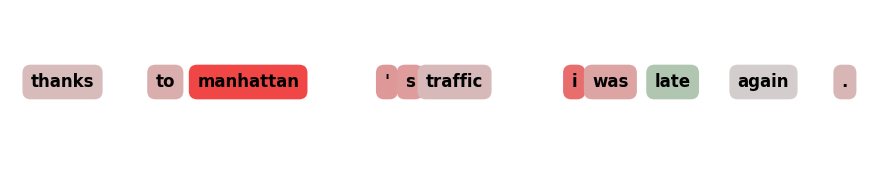

CPU times: user 107 ms, sys: 143 ms, total: 250 ms
Wall time: 83 ms


In [18]:
%%time

from captum.attr import GuidedBackprop

def xai_guidedbackprop(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = GuidedBackprop(wrapper)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_guidedbackprop(wrapper, input_ids, target_index, visual=True)

#### Deconvolution

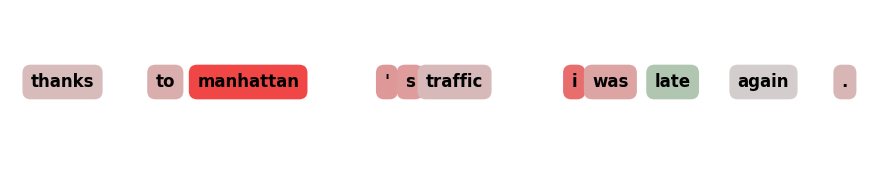

CPU times: user 112 ms, sys: 137 ms, total: 249 ms
Wall time: 82.7 ms


In [19]:
%%time

from captum.attr import Deconvolution

def xai_deconvolution(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = Deconvolution(wrapper)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_deconvolution(wrapper, input_ids, target_index, visual=True)

#### Lime

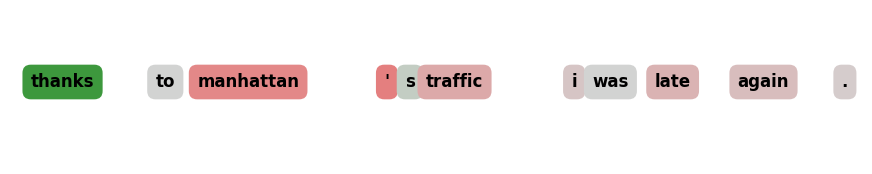

CPU times: user 1.42 s, sys: 2.37 s, total: 3.79 s
Wall time: 1.36 s


In [20]:
%%time

from captum.attr import Lime

def xai_lime(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = Lime(wrapper)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_lime(wrapper, input_ids, target_index, visual=True)

#### Guided GradCAM

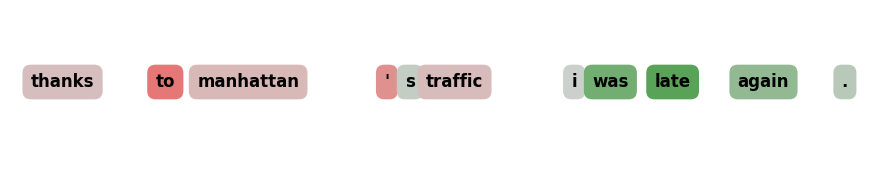

CPU times: user 126 ms, sys: 197 ms, total: 323 ms
Wall time: 127 ms


In [21]:
%%time

from captum.attr import GuidedGradCam

def xai_gradcam(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = GuidedGradCam(wrapper,wrapper.model.embedding)
    attributions = xai.attribute(input_embeddings, target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_gradcam(wrapper, input_ids, target_index, visual=True)

#### SHAP

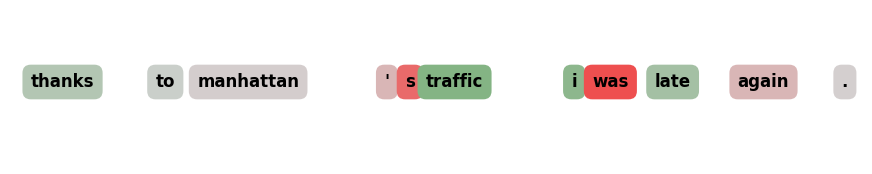

CPU times: user 142 ms, sys: 190 ms, total: 332 ms
Wall time: 133 ms


In [22]:
%%time

from captum.attr import GradientShap

def xai_shap(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = GradientShap(wrapper)
    attributions = xai.attribute(inputs=input_embeddings, baselines=torch.randn_like(input_embeddings), target=target)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_shap(wrapper, input_ids, target_index, visual=True)

#### Occlusion

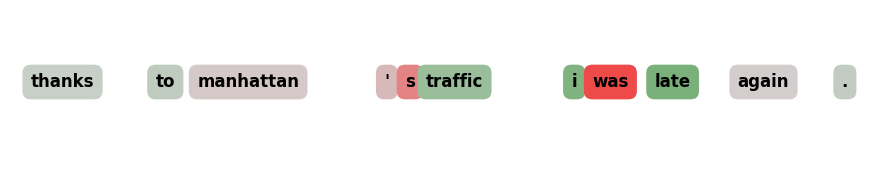

CPU times: user 10.5 s, sys: 3.58 s, total: 14.1 s
Wall time: 13.9 s


In [23]:
%%time

from captum.attr import Occlusion

def xai_occlusion(model, input, target, visual=False):

    input_embeddings = interpretable_embedding.indices_to_embeddings(input)
    xai = Occlusion(wrapper)
    attributions = xai.attribute(input_embeddings, sliding_window_shapes = (1, 3),target=target_index)
    attributions_l2, attributions_mean = normalize_attributions(attributions)

    if visual==True:
        visualize_attributions(attributions, input)

    return attributions, attributions_l2, attributions_mean

temp = xai_occlusion(wrapper, input_ids, target_index, visual=True)

## XAI METRICS

In [24]:
from captum.metrics import infidelity, sensitivity_max

# define a perturbation function for the input
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.01, inputs.shape)).float()
    return noise, inputs - noise

In [25]:
test_df.head()

,Content,Sentiment,id
0,there may not be a critic alive who harbors as...,Negative,N900
1,"renee zellweger stars as sonia , a young jewis...",Negative,N901
2,there 're so many things to criticize about i ...,Negative,N902
3,do n't let this movie fool you into believing ...,Negative,N903
4,it 's a good thing most animated sci - fi movi...,Negative,N904


In [26]:
# Initialize a list to store the objects
test_inputs = []

# Apply label conversion
test_df["label"] = test_df["Sentiment"].apply(lambda x: 1 if x == 'Positive' else 0)

# Iterate through each row of the DataFrame
for index, row in test_df.iterrows():
    text = row['Content']
    target_index = row['label']

    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get embeddings
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)

    # Convert input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

    # Remove special tokens ([CLS] and [SEP])
    tokens = [token.replace('##', '') for token in tokens if token not in tokenizer.all_special_tokens]

    # Create a dictionary for the current row
    data_object = {
        'text': text,
        'target_index': target_index,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'input_embeddings': input_embeddings,
        'tokens': tokens
    }

    # Append the dictionary to the list
    test_inputs.append(data_object)

In [27]:
output_dir = '/content/drive/MyDrive/CNNjson'
os.makedirs(output_dir, exist_ok=True)

In [28]:
import torch

def print_device_info():
    if torch.cuda.is_available():
        print("Using GPU:", torch.cuda.get_device_name(0))
    else:
        print("Using CPU")

print_device_info()

Using GPU: NVIDIA L4


In [29]:
%%time
import time
import json
import torch
import numpy as np
import os
from captum.attr import DeepLift, Saliency, IntegratedGradients, InputXGradient, GuidedBackprop, Deconvolution, Lime, GradientShap


xai_methods = [
    ("DeepLift", xai_deeplift),
    ("Saliency", xai_saliency),
    ("Integrated Gradients", xai_integratedgradients),
    ("InputXGradient", xai_inputgradient),
    ("GradL2", xai_gradl2),
    ("GuidedBackpropagation", xai_guidedbackprop),
    ("Deconvolution", xai_deconvolution),
    ("Lime", xai_lime),
    ("GradCAM", xai_gradcam),
    ("SHAP", xai_shap),
]

# Define the perturbation function
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.01, inputs.shape)).float().to(inputs.device)
    return noise, inputs - noise

# Iterate over the XAI methods and compute infidelities
for method_name, xai_function in xai_methods:
    res = []
    print(method_name)
    for i, test_input in enumerate(test_inputs):
        start_time = time.time()

        # Ensure the inputs are on the same device
        input_ids = test_input['input_ids'].to(device)
        input_embeddings = test_input['input_embeddings'].to(device)
        target_index = test_input['target_index']

        temp, temp_l2, temp_mean = xai_function(wrapper, input_ids, target_index, visual=False)

        end_time = time.time()
        elapsed_time = end_time - start_time

        infid_score = infidelity(
            forward_func=wrapper,
            perturb_func=perturb_fn,
            inputs=input_embeddings,
            attributions=temp,
            target=target_index
        ).item()

        result = {
            'index': i,
            'text': test_input['text'],
            'target_index': target_index,
            'tokens': test_input['tokens'],
            'weights_mean': temp_mean.tolist(),  # Convert tensor to list for serialization
            'weights_l2': temp_l2.tolist(),  # Convert tensor to list for serialization
            'elapsed_time': elapsed_time,
            "infidelity": np.round(infid_score, 5)
        }

        res.append(result)

    file = method_name + ".json"
    output_file = os.path.join(output_dir, file)
    res2 = [item for item in res if 'weights' not in item]
    with open(output_file, 'w') as f:
        json.dump(res2, f, indent=4)

    print(f"Results saved to {output_file}")


DeepLift
Results saved to /content/drive/MyDrive/CNNjson/DeepLift.json
Saliency
Results saved to /content/drive/MyDrive/CNNjson/Saliency.json
Integrated Gradients
Results saved to /content/drive/MyDrive/CNNjson/Integrated Gradients.json
InputXGradient
Results saved to /content/drive/MyDrive/CNNjson/InputXGradient.json
GradL2
Results saved to /content/drive/MyDrive/CNNjson/GradL2.json
GuidedBackpropagation
Results saved to /content/drive/MyDrive/CNNjson/GuidedBackpropagation.json
Deconvolution
Results saved to /content/drive/MyDrive/CNNjson/Deconvolution.json
Lime
Results saved to /content/drive/MyDrive/CNNjson/Lime.json
GradCAM
Results saved to /content/drive/MyDrive/CNNjson/GradCAM.json
SHAP
Results saved to /content/drive/MyDrive/CNNjson/SHAP.json
CPU times: user 1h 23min 25s, sys: 7min 46s, total: 1h 31min 12s
Wall time: 1h 18min 49s


In [30]:
# Load the JSONL file from the provided path
file_path = '/content/drive/MyDrive/test.jsonl'

# Load the JSONL file
with open(file_path, 'r') as file:
    evidence_data = [json.loads(line) for line in file]

# Function to generate annotation IDs
def generate_annotation_ids(prefix, start, end):
    return [f"{prefix}{i}.txt" for i in range(start, end + 1)]

# Generate annotation IDs for the ranges
neg_annotation_ids = generate_annotation_ids('negR_', 900, 999)
pos_annotation_ids = generate_annotation_ids('posR_', 900, 999)

# Combine both lists of annotation IDs
all_annotation_ids = neg_annotation_ids + pos_annotation_ids

# Extract evidence indices for all specified annotation IDs
evidence_list = []

for annotation_id in all_annotation_ids:
    evidence_indices = []
    for item in evidence_data:
        if item['annotation_id'] == annotation_id:
            for evidence in item['evidences']:
                for span in evidence:
                    evidence_indices.append((span['start_token'], span['end_token']))
    evidence_list.append({'annotation_id': annotation_id, 'evidence_indices': evidence_indices})

evidence_list[0]

{'annotation_id': 'negR_900.txt',
 'evidence_indices': [(40, 43),
  (58, 76),
  (106, 115),
  (182, 191),
  (241, 249),
  (320, 352),
  (419, 442),
  (530, 557),
  (559, 614)]}

In [31]:
# Function to mark evidence in token data
def mark_evidence(tokens, evidence_indices):
    evidence = [0] * len(tokens)
    for start, end in evidence_indices:
        for i in range(start, end):
            evidence[i] = 1
    return tokens, evidence

# Initialize a list to store the dictionaries
token_evidence_list = []


In [32]:
import itertools

# Process each row of test_df and fill the list with dictionaries
for i, row in test_df.iterrows():
    #print(i)
    id = row["id"]
    sentiment = row["Sentiment"]
    file = f"negR_{id[1:]}.txt" if sentiment == 'Negative' else f"posR_{id[1:]}.txt"
    text = row["Content"]
    tokens = text.split()

    evidence_indices = list(itertools.chain(*[row["evidence_indices"] for row in evidence_list if row['annotation_id'] == file]))
    tokens, evidence = mark_evidence(tokens, evidence_indices)

    # Create a dictionary for each row and append to the list
    token_evidence_list.append({'tokens': tokens, 'evidence': evidence})


# Print the resulting list of dictionaries
print(token_evidence_list[0])

{'tokens': ['there', 'may', 'not', 'be', 'a', 'critic', 'alive', 'who', 'harbors', 'as', 'much', 'affection', 'for', 'shlock', 'monster', 'movies', 'as', 'i', 'do', '.', 'i', 'delighted', 'in', 'the', 'sneaky', '-', 'smart', 'entertainment', 'of', 'ron', 'underwood', "'s", 'big', '-', 'underground', '-', 'worm', 'yarn', 'tremors', ';', 'i', 'even', 'giggled', 'at', 'last', 'year', "'s", 'critically', '-', 'savaged', 'big', '-', 'underwater', '-', 'snake', 'yarn', 'anaconda', '.', 'something', 'about', 'these', 'films', 'causes', 'me', 'to', 'lower', 'my', 'inhibitions', 'and', 'return', 'to', 'the', 'saturday', 'afternoons', 'of', 'my', 'youth', ',', 'spent', 'in', 'the', 'company', 'of', 'ghidrah', ',', 'the', 'creature', 'from', 'the', 'black', 'lagoon', 'and', 'the', 'blob', '.', 'deep', 'rising', ',', 'a', 'big', '-', 'undersea', '-', 'serpent', 'yarn', ',', 'does', "n't", 'quite', 'pass', 'the', 'test', '.', 'sure', 'enough', ',', 'all', 'the', 'modern', 'monster', 'movie', 'ingre

In [33]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and update evidence
def tokenize_and_update_evidence(data):
    new_tokens = []
    new_evidences = []

    for token, evidence in zip(data['tokens'], data['evidence']):
        tokenized = tokenizer.tokenize(token)
        # Remove '##' from tokenized tokens
        tokenized = [t.replace('##', '') for t in tokenized]
        new_tokens.extend(tokenized)
        new_evidences.extend([evidence] * len(tokenized))

    return {'tokens': new_tokens, 'evidence': new_evidences}

# Apply the function to each element in the token_evidence_list
updated_token_evidence_list = [tokenize_and_update_evidence(item) for item in token_evidence_list]

# Display the updated list of dictionaries
print(updated_token_evidence_list[0])

{'tokens': ['there', 'may', 'not', 'be', 'a', 'critic', 'alive', 'who', 'harbor', 's', 'as', 'much', 'affection', 'for', 'sh', 'lock', 'monster', 'movies', 'as', 'i', 'do', '.', 'i', 'delighted', 'in', 'the', 'sneak', 'y', '-', 'smart', 'entertainment', 'of', 'ron', 'underwood', "'", 's', 'big', '-', 'underground', '-', 'worm', 'yarn', 'tremor', 's', ';', 'i', 'even', 'giggled', 'at', 'last', 'year', "'", 's', 'critically', '-', 'savage', 'd', 'big', '-', 'underwater', '-', 'snake', 'yarn', 'ana', 'con', 'da', '.', 'something', 'about', 'these', 'films', 'causes', 'me', 'to', 'lower', 'my', 'inhibition', 's', 'and', 'return', 'to', 'the', 'saturday', 'afternoons', 'of', 'my', 'youth', ',', 'spent', 'in', 'the', 'company', 'of', 'g', 'hid', 'rah', ',', 'the', 'creature', 'from', 'the', 'black', 'lagoon', 'and', 'the', 'b', 'lo', 'b', '.', 'deep', 'rising', ',', 'a', 'big', '-', 'under', 'sea', '-', 'serpent', 'yarn', ',', 'does', 'n', "'", 't', 'quite', 'pass', 'the', 'test', '.', 'sure

In [34]:
# Remove interpretable embedding layer after attribution
remove_interpretable_embedding_layer(model, interpretable_embedding)

### Counterfactual explanations

In [35]:
from torch.nn.functional import softmax

def predict_proba(texts):
    # Tokenize the input
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)  # Get the token IDs and move them to the device

    # Make predictions
    with torch.no_grad():
        logits = model(input_ids)
        probabilities = softmax(logits, dim=1)  # Apply softmax to get probabilities

    return probabilities.cpu().numpy()


In [36]:
%%time

def extract_top_tokens(res_xai, num_top_tokens=5, method = "mean"):
    top_tokens = []

    for idx, result in enumerate(res_xai):
        #print(idx)

        inputs = tokenizer(result['text'], return_tensors="pt", truncation=True, padding=True, max_length=512)
        # Remove the first and the last tokens
        inputs['input_ids'] = inputs['input_ids'][:, 1:-1]

        tokenized_text = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

        # Zip tokens with their corresponding weights_mean and their positions
        if method == "mean":
            token_weights = list(zip(tokenized_text, result['weights_mean'], range(len(result['tokens']))))
        elif method == "L2":
            token_weights = list(zip(tokenized_text, result['weights_l2'], range(len(result['tokens']))))
        elif method == "direct":
            token_weights = list(zip(tokenized_text, result['weights'], range(len(result['tokens']))))

        #print(range(len(result['tokens'])))
        # Filter out tokens with '##' and the token before them
        filtered_token_weights = []
        skip_next = False
        for i in range(len(result['tokens'])):

            if skip_next:
                skip_next = False
                continue
            token, weight, position = token_weights[i]

            if '##' in token:
                if filtered_token_weights:  # Ensure the list is not empty before popping
                    filtered_token_weights.pop()  # Remove the previous token
                skip_next = True
            else:
                filtered_token_weights.append((token, weight, position))

        # Filter out non-alphabetic tokens
        token_weights = [(token, weight, position) for token, weight, position in filtered_token_weights if token.isalpha() and (len(token) > 1 or token in ['i', 'a'])]


        # Sort tokens by weights_mean in descending order
        sorted_tokens = sorted(token_weights, key=lambda x: x[1], reverse=True)

        # Get the top tokens
        top_n = sorted_tokens[:num_top_tokens]
        top_tokens.append({
            'index': result['index'],
            'text': result['text'],
            'top_tokens': [(token, weight, position) for token, weight, position in top_n]
        })

    return top_tokens

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [37]:
import random
from transformers import BertForMaskedLM

# Function to set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load the pre-trained BERT model and tokenizer for masked language modeling
mlm_bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
mlm_bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

mlm_bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [38]:
%%time

import random
import torch
from transformers import set_seed


def generate_counterfactuals_with_positions_all_mask(original_text, important_tokens_with_positions, num_samples=10, seed=None):
    if seed is not None:
        set_seed(seed)

    counterfactuals = []
    replacement_words = []

    # Tokenize the original text
    inputs = mlm_bert_tokenizer(original_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to device
    tokenized_text = mlm_bert_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Replace all important tokens with [MASK]
    new_tokenized_text = tokenized_text[:]
    positions = [pos + 1 for _, _, pos in important_tokens_with_positions]  # Increment positions by 1 to account for [CLS] token

    for position in positions:
        if position <= len(new_tokenized_text):
            new_tokenized_text[position] = "[MASK]"

    masked_text = mlm_bert_tokenizer.convert_tokens_to_string(new_tokenized_text[1:-1])  # Delete the CLS and SEP before tokenizing again

    new_inputs = mlm_bert_tokenizer(masked_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    new_inputs = {k: v.to(device) for k, v in new_inputs.items()}  # Move new_inputs to device

    # Ensure we have mask token indices
    mask_token_indices = torch.where(new_inputs['input_ids'] == mlm_bert_tokenizer.mask_token_id)[1]

    if len(mask_token_indices) == 0:
        return counterfactuals, replacement_words

    with torch.no_grad():
        outputs = mlm_bert_model(**new_inputs)
    logits = outputs.logits

    # Generate replacements for each masked token
    all_replacements = []
    for mask_token_index, pos in zip(mask_token_indices, positions):
        original_word = tokenized_text[pos]  # Get the original word
        mask_token_logits = logits[0, mask_token_index, :]
        top_k_words = torch.topk(mask_token_logits, num_samples * 10, dim=-1).indices.tolist()

        # Filter words
        filtered_words = []
        for word_id in top_k_words:
            word = mlm_bert_tokenizer.decode([word_id]).strip()
            if word.isalpha() and word not in filtered_words and word.lower() != original_word.lower():  # Ensure the word is alphabetic, unique, and not the same as the original word
                filtered_words.append(word)
        # Select 10 randomly from the filtered words
        selected_words = random.sample(filtered_words, min(num_samples, len(filtered_words)))

        all_replacements.append(selected_words)

    # Generate 10 counterfactuals by selecting one replacement for each masked word
    for i in range(num_samples):
        comb_tokenized_text = new_tokenized_text[:]
        replacements = []
        for j, position in enumerate(positions):
            if position < len(comb_tokenized_text):
                word = all_replacements[j][i % len(all_replacements[j])]
                comb_tokenized_text[position] = word
                replacements.append((tokenized_text[position], word))
        comb_tokenized_text = comb_tokenized_text[1:-1]  # Remove [CLS] and [SEP] tokens
        counterfactual_text = mlm_bert_tokenizer.convert_tokens_to_string(comb_tokenized_text)
        counterfactuals.append(counterfactual_text)
        replacement_words.append(replacements)

    return counterfactuals, replacement_words

CPU times: user 3.43 ms, sys: 0 ns, total: 3.43 ms
Wall time: 3.33 ms


In [39]:
%%time

# Define the function to apply the counterfactual generation
def apply_counterfactual_generation(top_tokens_list, num_samples=10, seed=27):
    counterfactuals_dict = {}
    for i, top_tokens in enumerate(top_tokens_list):
        original_text = top_tokens['text']
        important_tokens_with_positions = top_tokens['top_tokens']

        counterfactual_texts, replacement_words = generate_counterfactuals_with_positions_all_mask(
            original_text, important_tokens_with_positions, num_samples=num_samples, seed=seed
        )

        counterfactuals_dict[i] = {
            "original_text": original_text,
            "important_tokens_with_positions": important_tokens_with_positions,
            "counterfactual_texts": counterfactual_texts,
            "replacement_words": replacement_words
        }

    return counterfactuals_dict

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


In [40]:
from transformers import BertModel

def validity_soft(original_texts, counterfactual_texts, predict_proba, target_index):
    """Compute Validity_soft metric."""
    N = len(original_texts)
    validity_sum = 0.0
    original_proba = predict_proba(original_texts)[0]

    for counterfactual in counterfactual_texts:

        counterfactual_proba = predict_proba(counterfactual)[0]
        validity_sum += original_proba[target_index] - counterfactual_proba[target_index]  # the first is the negative and the second positive.

    validity_soft_value = validity_sum / N
    return validity_soft_value


# Load a separate model for getting embeddings
embedding_model = BertModel.from_pretrained('bert-base-uncased')
embedding_model.to(device)
embedding_model.eval()

def get_bert_embeddings(texts):
    """Get BERT embeddings for a list of texts."""
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = embedding_model(input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling of token embeddings

    return embeddings.cpu().numpy()

def c_soft(original_texts, counterfactual_texts, predict_proba, target_index):
    """Compute C_soft metric."""
    N = len(original_texts)
    validity_soft_sum = 0.0
    proximity_sum = 0.0

    original_proba = predict_proba(original_texts)[0]

    original_embeddings = get_bert_embeddings(original_texts)
    counterfactual_embeddings = get_bert_embeddings(counterfactual_texts)

    for counterfactual, orig_emb, cf_emb in zip(counterfactual_texts, original_embeddings, counterfactual_embeddings):

        counterfactual_proba = predict_proba([counterfactual])[0]
        validity_soft_sum += original_proba[target_index] - counterfactual_proba[target_index]

        proximity_sum += np.linalg.norm(orig_emb - cf_emb)


    c_soft_value = validity_soft_sum / proximity_sum
    return c_soft_value


In [41]:
from sklearn.metrics import average_precision_score
import statistics

df_final = pd.DataFrame(columns=['XAI', 'MAP Mean', 'MAP L2', 'Infidelity', 'Time Mean', 'Time Std'])

for method_name, xai_function in xai_methods:
    start_time = time.time()

    print(method_name)
    file=method_name+".json"
    file_path = os.path.join(output_dir, file)

    # Open the JSON file
    with open(file_path, 'r') as file:
        # Load the JSON data
        res = json.load(file)

    l2_MAP = []
    mean_MAP = []
    infidelity_df = []
    val_mean_df = []
    val_l2_df = []
    soft_mean_df = []
    soft_l2_df = []

    top_tokens_mean = extract_top_tokens(res, num_top_tokens=5, method="mean")
    counterfactual_mean = apply_counterfactual_generation(top_tokens_mean, num_samples=10, seed=27)

    top_tokens_l2 = extract_top_tokens(res, num_top_tokens=5, method="L2")
    counterfactual_l2 = apply_counterfactual_generation(top_tokens_l2, num_samples=10, seed=27)

    for i, attributions in enumerate(res):
        # Ensure both have the same length
        min_length = min(len(attributions['weights_l2']), 510)

        # Trim the data to have the same length
        evidence_trimmed = updated_token_evidence_list[i]['evidence'][:min_length]
        attr_l2 = attributions['weights_l2']

        # Compute the average precision score
        average_precision_l2 = average_precision_score(evidence_trimmed, attr_l2)

        l2_MAP.append(average_precision_l2)

        attr_mean = attributions['weights_mean']

        # Compute the average precision score
        average_precision_mean = average_precision_score(evidence_trimmed, attr_mean)

        mean_MAP.append(average_precision_mean)

        infid = attributions['infidelity']

        infidelity_df.append(infid)


        #counter mean

        original_text_mean = counterfactual_mean[i]['original_text']
        counterfactual_text_mean = counterfactual_mean[i]['counterfactual_texts']

        val_mean = validity_soft(original_text_mean,counterfactual_text_mean, predict_proba, attributions['target_index'])
        soft_mean = c_soft(original_text_mean,counterfactual_text_mean, predict_proba, attributions['target_index'])

        val_mean_df.append(val_mean)
        soft_mean_df.append(soft_mean)


        #counter l2


        original_text_l2 = counterfactual_l2[i]['original_text']
        counterfactual_text_l2 = counterfactual_l2[i]['counterfactual_texts']

        val_l2 = validity_soft(original_text_l2,counterfactual_text_l2, predict_proba, attributions['target_index'])
        soft_l2 = c_soft(original_text_l2,counterfactual_text_l2, predict_proba, attributions['target_index'])

        val_l2_df.append(val_l2)
        soft_l2_df.append(soft_l2)


    # Calculate the metrics
    map_mean = statistics.mean(mean_MAP)
    map_l2 = statistics.mean(l2_MAP)
    infidelity_mean = statistics.mean(infidelity_df)
    xai_times = [item['elapsed_time'] for item in res]
    time_mean = statistics.mean(xai_times)
    time_std = statistics.stdev(xai_times)
    val_mean = statistics.mean(val_mean_df)
    soft_mean = statistics.mean(soft_mean_df)
    val_l2 = statistics.mean(val_l2_df)
    soft_l2 = statistics.mean(soft_l2_df)

    new_row = {
        'XAI': method_name,
        'MAP Mean': map_mean,
        'MAP L2': map_l2,
        'Infidelity': infidelity_mean,
        'Time Mean': time_mean,
        'Time Std': time_std,
        'Val Mean': val_mean,
        'Val L2': val_l2,
        'Soft Mean': soft_mean,
        'Soft L2': soft_l2
    }

    # Convert the new_row dictionary to a DataFrame
    new_row_df = pd.DataFrame([new_row])

    # Concatenate the new row to the existing DataFrame
    df_final = pd.concat([df_final, new_row_df], ignore_index=True)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time: {elapsed_time}")

DeepLift
Time: 187.15638375282288
Saliency
Time: 185.41300773620605
Integrated Gradients
Time: 183.55542993545532
InputXGradient
Time: 181.72148895263672
GradL2
Time: 181.65716910362244
GuidedBackpropagation
Time: 182.23040795326233
Deconvolution
Time: 181.72927403450012
Lime
Time: 181.542662858963
GradCAM
Time: 182.15546035766602
SHAP
Time: 182.3495683670044


In [42]:
%%time

df_final.round(8)

CPU times: user 143 µs, sys: 0 ns, total: 143 µs
Wall time: 148 µs


,XAI,MAP Mean,MAP L2,Infidelity,Time Mean,Time Std,Val Mean,Val L2,Soft Mean,Soft L2
0,DeepLift,0.280178,0.283557,6.405000e-05,0.004503,0.003268,0.000475,0.000096,0.485205,0.083665
1,Saliency,0.283703,0.283840,6.935000e-05,0.002973,0.000930,0.000061,0.000063,0.064545,0.061944
2,Integrated Gradients,0.280203,0.283486,6.490000e-05,0.071171,0.007934,0.000474,0.000099,0.481478,0.094956
3,InputXGradient,0.280178,0.283557,6.910000e-05,0.002712,0.000309,0.000475,0.000096,0.485205,0.083665
4,GradL2,0.267827,0.283840,3.000000e-07,0.003253,0.001209,-0.000027,0.000063,-0.039813,0.061944
5,GuidedBackpropagation,0.267827,0.283840,3.000000e-07,0.002672,0.000224,-0.000027,0.000063,-0.039813,0.061944
6,Deconvolution,0.267827,0.283840,2.000000e-07,0.002651,0.000256,-0.000027,0.000063,-0.039813,0.061944
7,Lime,0.267737,0.270292,3.140000e-05,17.303985,3.922383,0.000011,0.000014,0.014871,0.016456
8,GradCAM,0.270946,0.283157,3.215000e-05,0.005678,0.000428,0.000056,0.000066,0.064536,0.067879
9,SHAP,0.276594,0.281154,7.240000e-05,0.004722,0.002737,0.000456,0.000105,0.435567,0.109902
